In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [297]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r = d['target_r']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


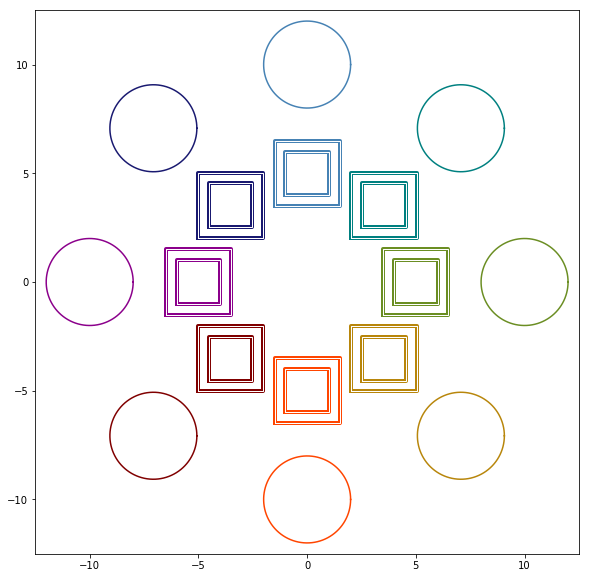

In [4]:
#Plot the targets and obstacles: 
plot_target = True
plot_obs_big = True
plot_obs_small = True

plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)

plt.figure(figsize=plot['size'])

if plot_obs_small:
    bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
if plot_obs_big:
    bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
if plot_target: 
    bmi_util.plot_targets(target_pos, target_color, target_r*np.ones(num_targets))                
plt.axis('square')
plt.xlim(plot['xlim'])
plt.ylim(plot['ylim'])
plt.show()


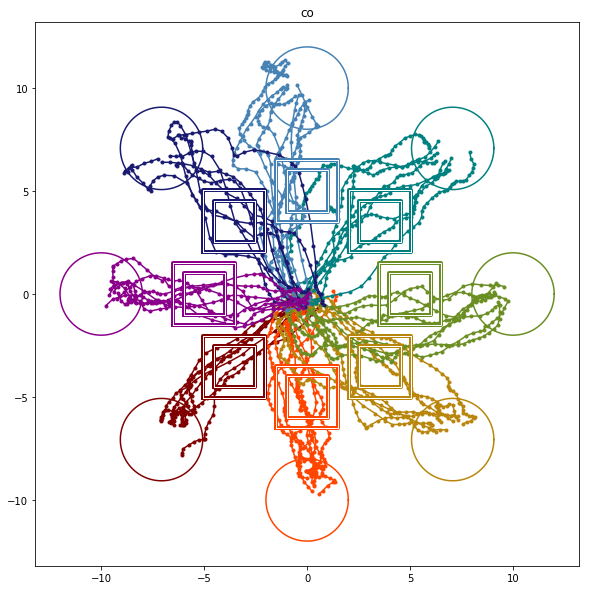

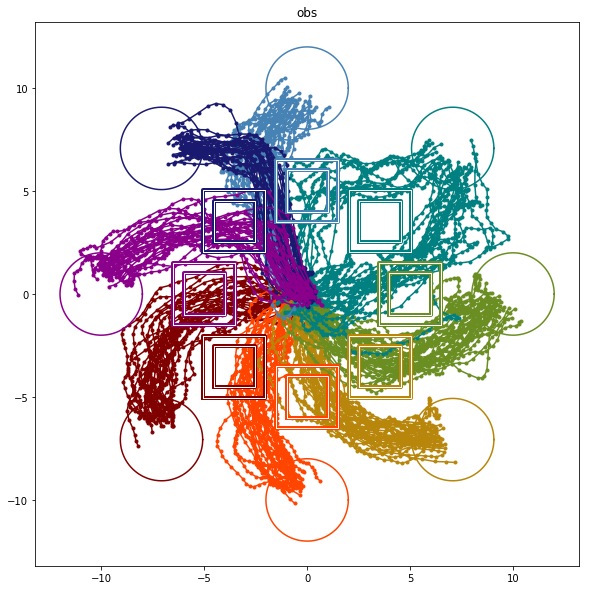

In [5]:
#PLOT INDIVIDUAL TRIALS: 
plot={}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)

for task_str in task_list:
    task = task2idx[task_str]
    plt.figure(figsize=plot['size'])
    for target in range(num_targets):
        sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target)
        df_sel = df[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.hstack((trial_start[1:]-1, len(np.where(sel)[0])))
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
#             print(x)
            color = target_color[target]
            plt.plot(x,y,'.-',color=color)

    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r*np.ones(num_targets))  
    
    plt.axis('square')
    plt.title(task_str)
#     plt.xlim(plot['xlim'])
#     plt.ylim(plot['ylim'])
    plt.show()

In [99]:
#xarray for variable x time x trial: 
num_var = df.shape[1]
time_win = np.array([0, 80])
num_time = np.diff(time_win)[0]
da_dic = {}
for task_str in task_list:
    task = task2idx[task_str]
    for target in range(num_targets):
        sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target)
        df_sel = df[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.hstack((trial_start[1:]-1, len(np.where(sel)[0])))
        trial_bound = np.vstack((trial_start,trial_stop)).T
        num_trials = trial_bound.shape[0]
        #------------------------------------------------------------------------------------
        #Initialize a nan-filled xarray
        nan_mat = np.ones((num_var, num_time, num_trials))*np.nan
        da = xr.DataArray(nan_mat,
                    coords={'var':list(df.columns),
                                     'time':range(num_time),
                                     'trial':range(num_trials)},
                    dims=['var','time','trial'])
        for trial, bnd in enumerate(trial_bound): #trial_bound[0:1,:]:
            trial_len = bnd[1]-bnd[0]
            if trial_len <= num_time:
                bnd[1] = bnd[0] + trial_len
            else:
                bnd[1] = bnd[0] + num_time
            trial_len_trunc = bnd[1]-bnd[0]
                
            da[:,:trial_len_trunc,trial] = df_sel[bnd[0]:bnd[1]].T
        da_dic[(task,target)] = da      

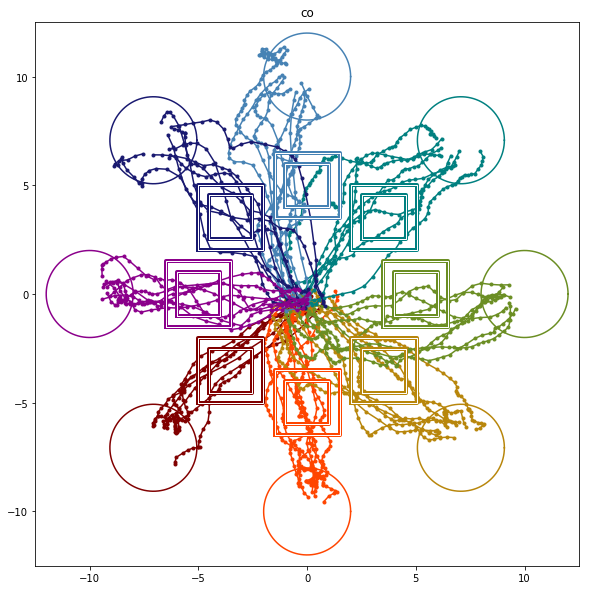

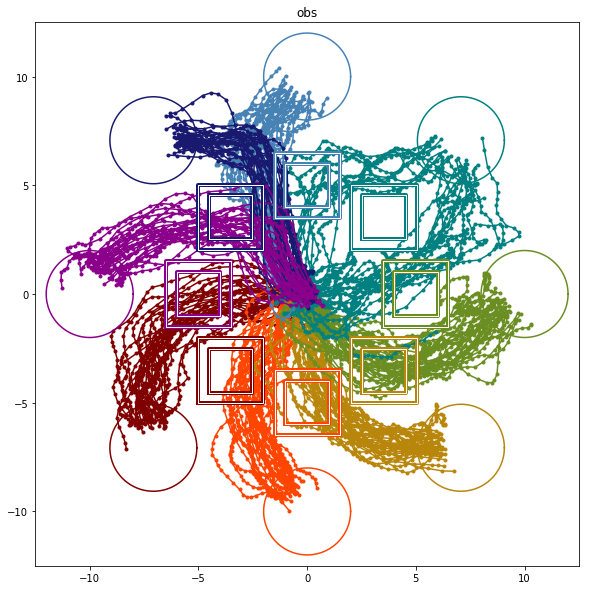

In [122]:
#PLOT ALL DATA in da_dic
for task_str in task_list:
    task = task2idx[task_str]
    plt.figure(figsize=plot['size'])
    for target in range(num_targets):
        da = da_dic[task,target]
        x = da.loc['kin_px',:,:] #num_time X num_trials
        y = da.loc['kin_py',:,:]
        color = target_color[target]
        plt.plot(x, y, '.-', color=color)
    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r*np.ones(num_targets))  
    
    plt.axis('square')
    plt.title(task_str)
    plt.xlim(plot['xlim'])
    plt.ylim(plot['ylim'])
    plt.show()

In [192]:
psth_dic = {}
for task in range(num_tasks):
    for target in range(num_targets):
        mean = da_dic[task,target].mean(axis=2,skipna=True)
        N = np.logical_not(np.isnan(da_dic[task,target])).sum(axis=2)
        var = da_dic[task,target].var(axis=2,skipna=True)
        sem = (var/N)**(0.5)
        
        psth_dic[task,target,'mean'] = mean
        psth_dic[task,target,'N'] = N
        psth_dic[task,target,'var'] = var
        psth_dic[task,target,'sem'] = sem

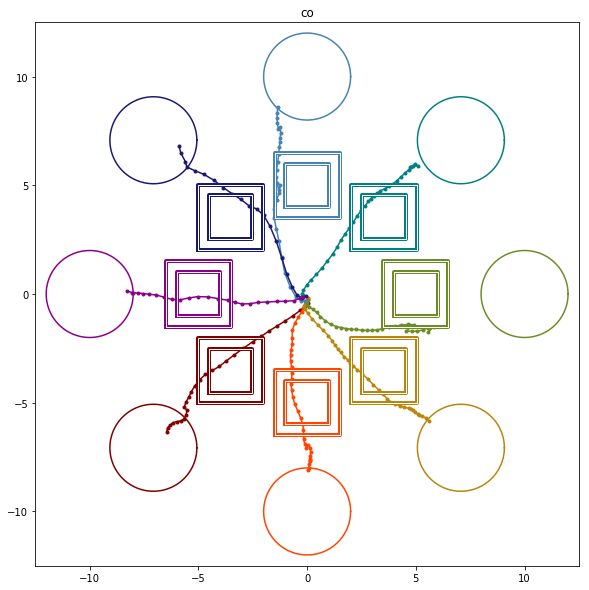

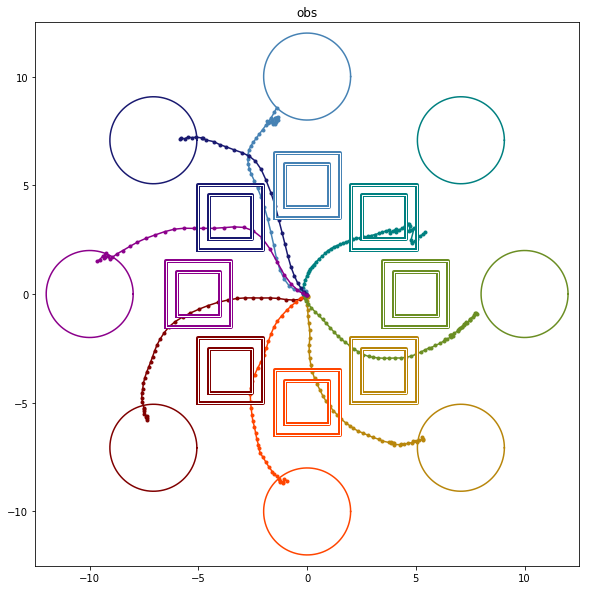

In [194]:
#PLOT ALL DATA in da_dic
plot_len = 50
for task_str in task_list:
    task = task2idx[task_str]
    plt.figure(figsize=plot['size'])
    for target in range(num_targets):
        data = psth_dic[task,target,'mean']
        count = psth_dic[task,target,'N']
        plt_len = data.shape[0]
        tmp = np.where(count.loc['kin_px'] < 6)[0]
        if len(tmp) > 0:
            plt_len = tmp[0]
        
        x = data.loc['kin_px'][:plt_len] #num_time X num_trials
        y = data.loc['kin_py'][:plt_len]
        color = target_color[target]
        plt.plot(x, y, '.-', color=color)
    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r*np.ones(num_targets))  
    
    plt.axis('square')
    plt.title(task_str)
    plt.xlim(plot['xlim'])
    plt.ylim(plot['ylim'])
    plt.show()

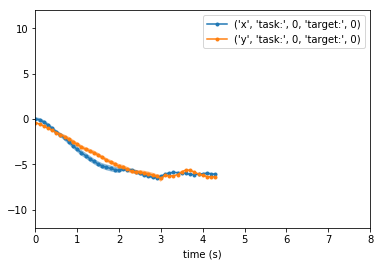

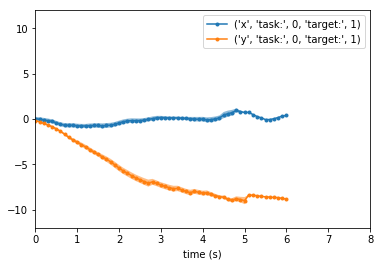

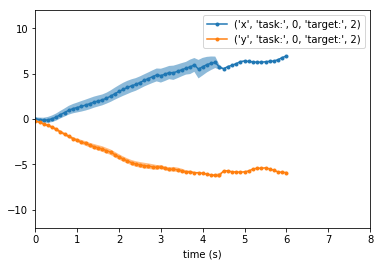

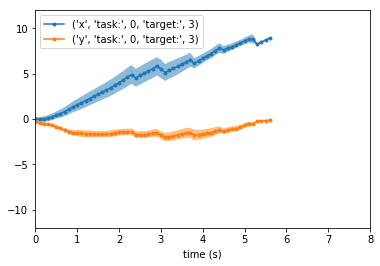

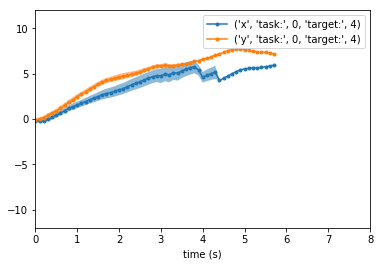

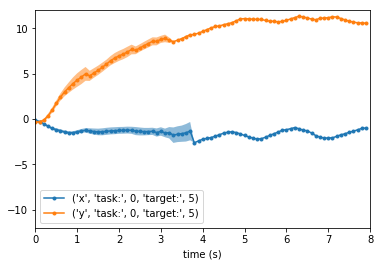

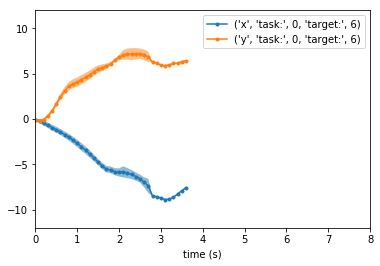

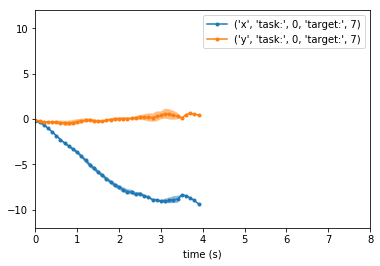

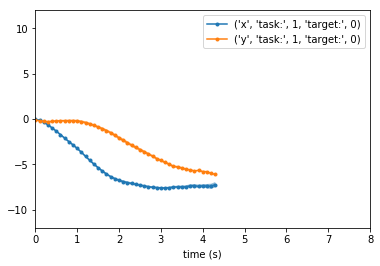

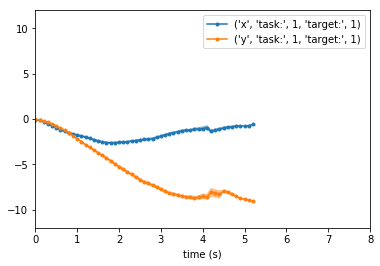

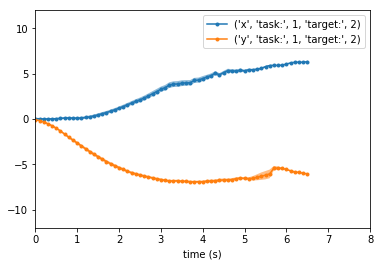

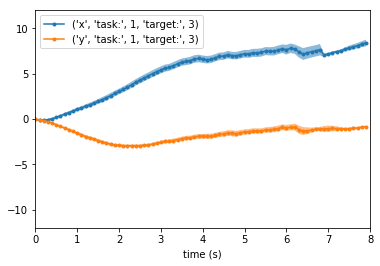

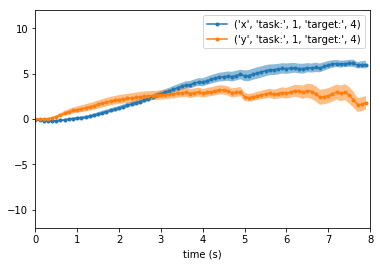

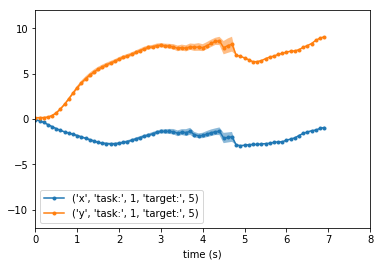

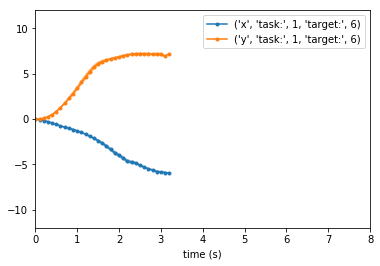

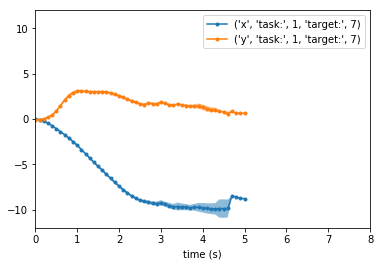

In [206]:
#Plot x,y together for each condition:
for task in range(num_tasks):
    for target in range(num_targets):
        t = psth_dic[task,target,'mean']['time']*sample_period
        
        x = psth_dic[task,target,'mean'].loc['kin_px']
        x_sem = psth_dic[task,target,'sem'].loc['kin_px']
        y = psth_dic[task,target,'mean'].loc['kin_py']
        y_sem = psth_dic[task,target,'sem'].loc['kin_py']
        
        #Plot: 
        plt.figure()
        plt.plot(t,x,'.-',label=('x','task:',task,'target:', target)) #,color=target_color[target]
        plt.fill_between(t, x-x_sem,x+x_sem,alpha=0.5) #,color=target_color[target]
        
        plt.plot(t,y,'.-',label=('y','task:',task,'target:', target)) #,color=target_color[target]
        plt.fill_between(t, y-y_sem,y+y_sem,alpha=0.5) #,color=target_color[target]        
        plt.legend()
        plt.xlabel('time (s)')
        plt.xlim([0, 8])
        plt.ylim([-12,12])

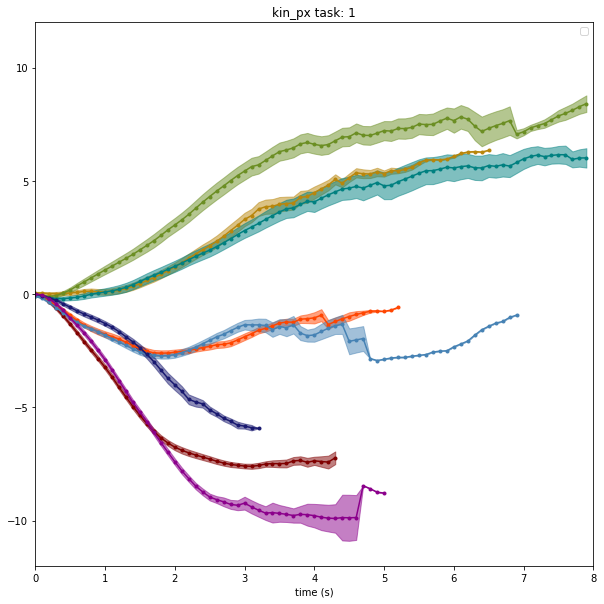

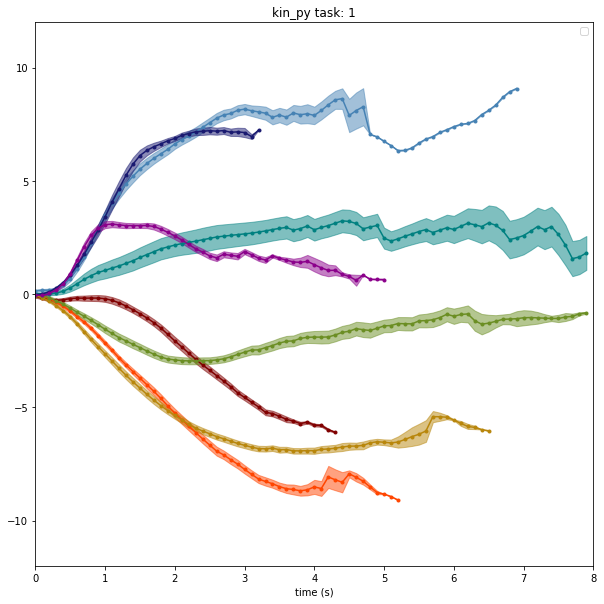

In [219]:
#Plot all conditions together:
plot_data = ['kin_px', 'kin_py']
for d in plot_data:
    for task in [1]:
        plt.figure(figsize=(10,10))
        for target in range(num_targets):
            t = psth_dic[task,target,'mean']['time']*sample_period
            x = psth_dic[task,target,'mean'].loc[d]
            x_sem = psth_dic[task,target,'sem'].loc[d]

            #Plot: 
            plt.plot(t,x,'.-', color=target_color[target])
            plt.fill_between(t, x-x_sem,x+x_sem,alpha=0.5,color=target_color[target])
        plt.legend()
        plt.title(d + ' task: ' + str(task))
        plt.xlabel('time (s)')
        plt.xlim([0, 8])
        plt.ylim([-12,12])

[-135.  -90.  -45.    0.   45.   90.  135.  180.]


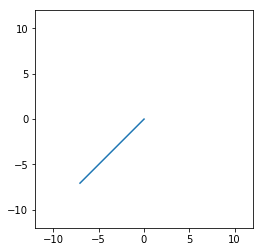

In [295]:
# # Plot target position: 
# target = 0
# plt.figure()
# plt.plot([0, target_pos[target,0]], [0, target_pos[target,1]])
# plt.axis('square')
# plt.xlim([-12, 12])
# plt.ylim([-12, 12])

# target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])*180/np.pi
# print(target_angle)

In [373]:
#Plot magnitude and angle psth: 
#ToDo:
#delta_position
ctrl = {}
for task in range(num_tasks):
    for target in range(num_targets):
        d_i = da_dic[task,target]
        p = d_i.loc['kin_px':'kin_py']
        v = d_i.loc['kin_vx':'kin_vy']
        u_p = d_i.loc['u_px':'u_py']
        u_v = d_i.loc['u_vx':'u_vy']
        
        ctrl[task, target, 'p_mag'] = np.linalg.norm(p, ord=1, axis=0)
        ctrl[task, target, 'p_angle'] = np.arctan2(d_i.loc['kin_py'], d_i.loc['kin_px'])
         #-target_angle[target])%(2*np.pi)
        ctrl[task, target, 'v_mag'] = np.linalg.norm(v, ord=1, axis=0)
        ctrl[task, target, 'v_angle'] = np.arctan2(d_i.loc['kin_vy'], d_i.loc['kin_vx'])
        ctrl[task, target, 'u_p_mag'] = np.linalg.norm(u_p, ord=1, axis=0)
        ctrl[task, target, 'u_p_angle'] = np.arctan2(d_i.loc['u_py'], d_i.loc['u_px'])        
        ctrl[task, target, 'u_v_mag'] = np.linalg.norm(u_v, ord=1, axis=0)
        ctrl[task, target, 'u_v_angle'] = np.arctan2(d_i.loc['u_vy'], d_i.loc['u_vx'])

ctrl_list = ['p_mag', 'p_angle', 'v_mag', 'v_angle', 'u_v_mag', 'u_v_angle', 'u_p_mag', 'u_p_angle']
ctrl_psth = {}
for task in range(num_tasks):
    for target in range(num_targets):
        for d in ctrl_list:
            data = ctrl[task, target, d]
            data = np.ma.array(data,mask=np.isnan(data))
            mean = data.mean(axis=1)
            N = np.logical_not(np.isnan(data)).sum(axis=1)
            var = data.var(axis=1)
            sem = (var/N)**(0.5)
            
            ctrl_psth[task,target, d, 'mean'] = mean
            ctrl_psth[task,target, d, 'N'] = N
            ctrl_psth[task,target, d, 'var'] = var
            ctrl_psth[task,target, d, 'sem'] = sem
            

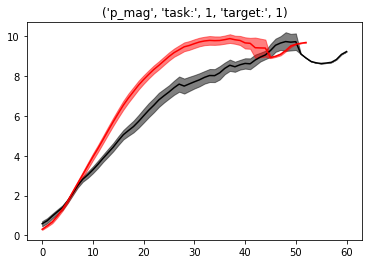

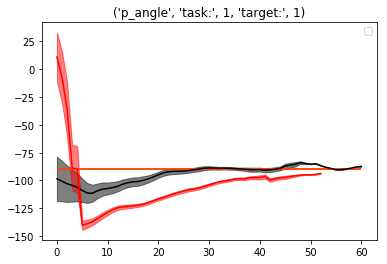

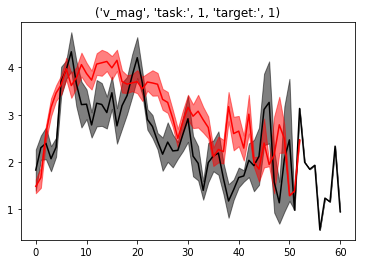

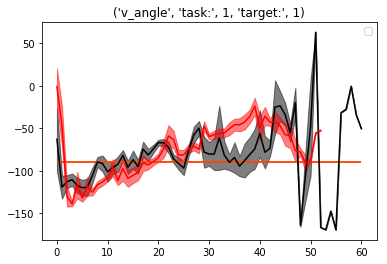

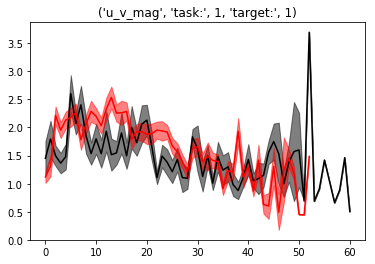

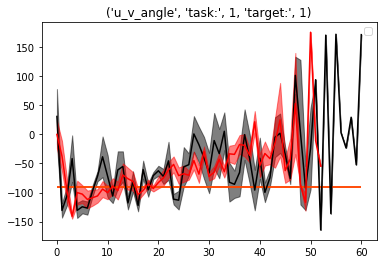

In [375]:
ctrl_list = ['p_mag', 'p_angle', 'v_mag', 'v_angle', 'u_v_mag', 'u_v_angle'] #'u_p_mag', 'u_p_angle',
# ['p_angle']#
task = 0
# target = 0
plot_trials =False

task_color = ['k', 'r']

for target in [1]: #range(num_targets):
    for d in ctrl_list: 
        plt.figure()
        for task in [0,1]:
            y = ctrl[task,target,d]
            y_mean = ctrl_psth[task,target,d,'mean']
            y_sem = ctrl_psth[task,target,d,'sem']    
            if 'angle' in d:
                y = y*180/np.pi
                y_mean = y_mean*180/np.pi
                y_sem = y_sem*180/np.pi 

                plt.hlines(target_angle[target]*180/np.pi,0,60,color=target_color[target])
                plt.legend()

            if plot_trials:
                r = plt.plot(y, color='k')


            plt.plot(y_mean, color=task_color[task])
            plt.fill_between(range(len(y)), y_mean-y_sem,y_mean+y_sem,alpha=0.5,color=task_color[task])
            plt.title((d, 'task:', task, 'target:', target))


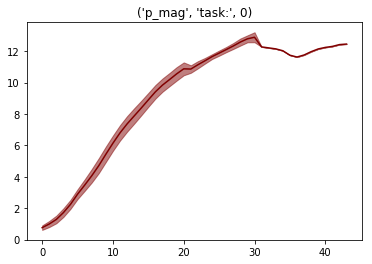

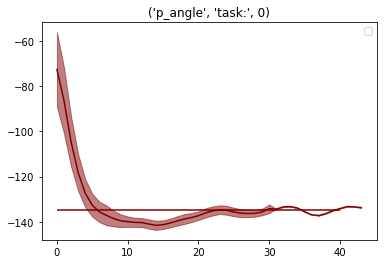

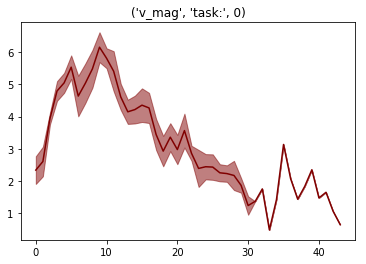

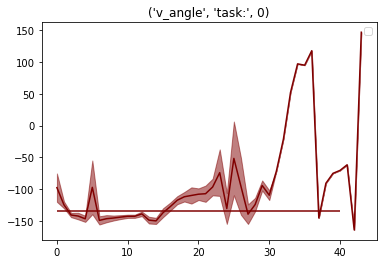

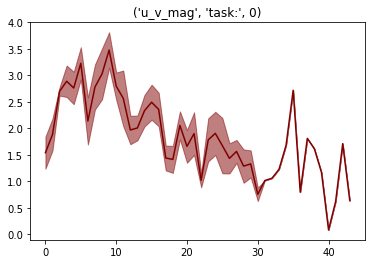

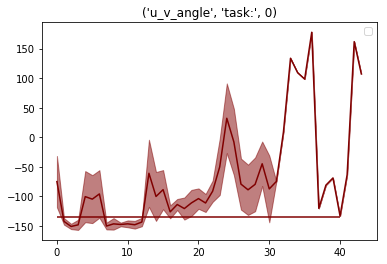

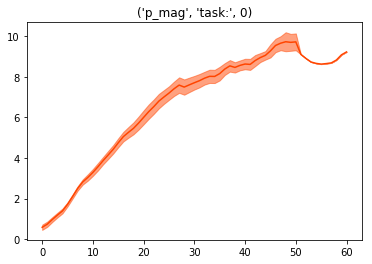

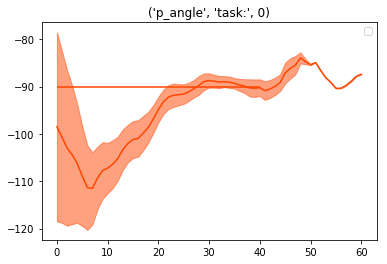

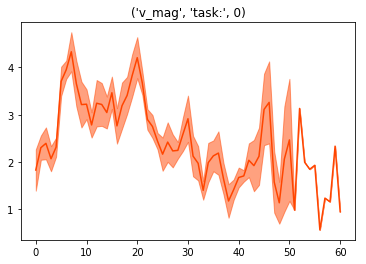

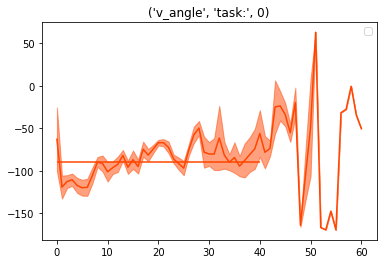

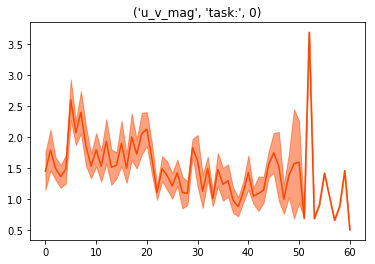

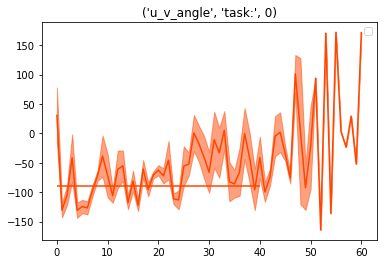

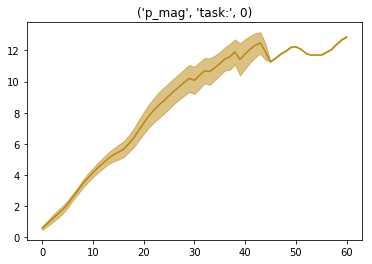

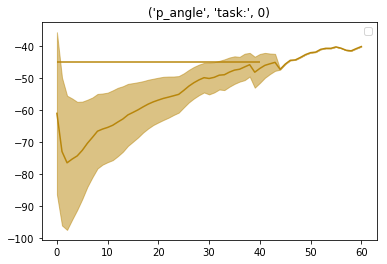

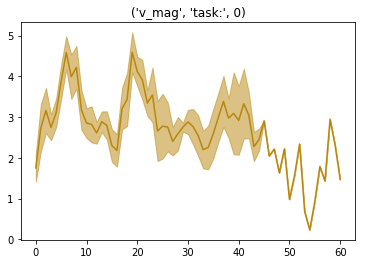

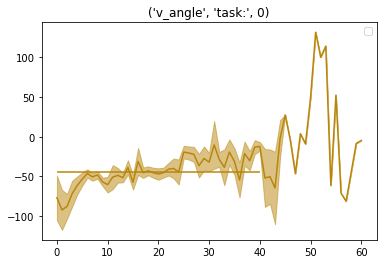

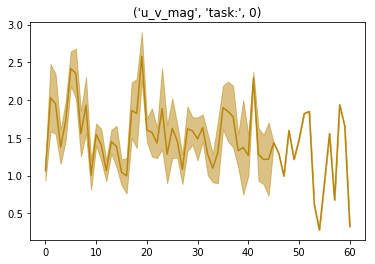

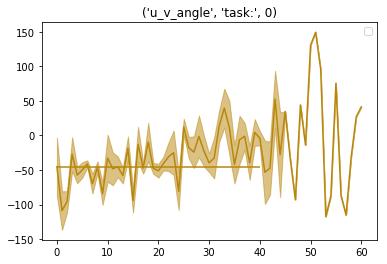

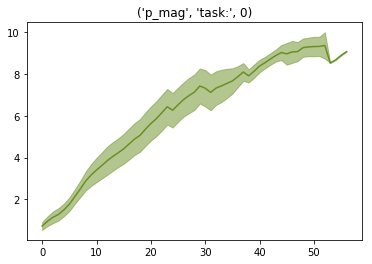

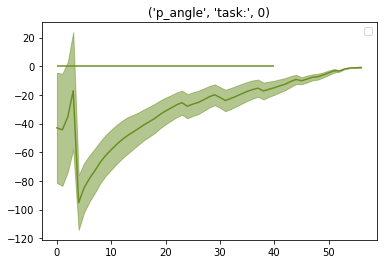

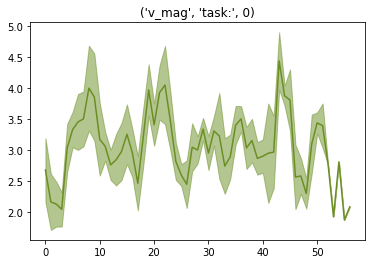

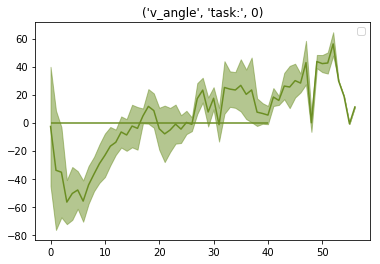

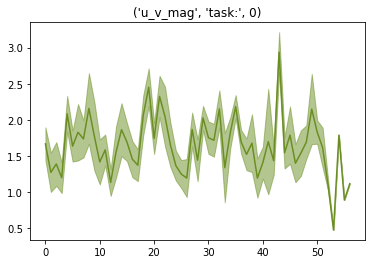

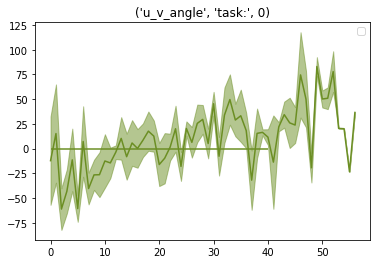

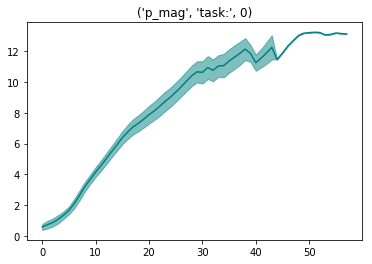

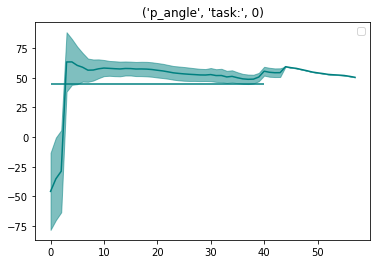

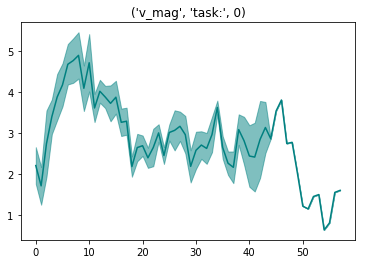

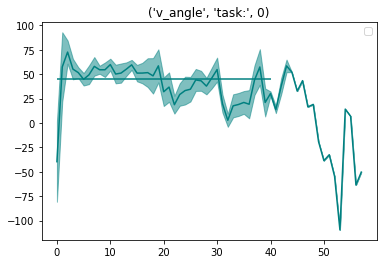

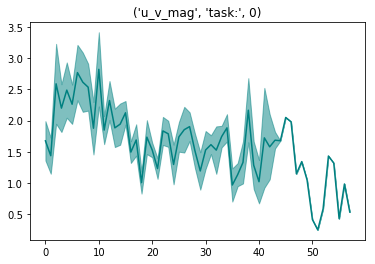

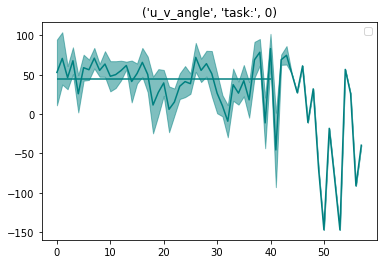

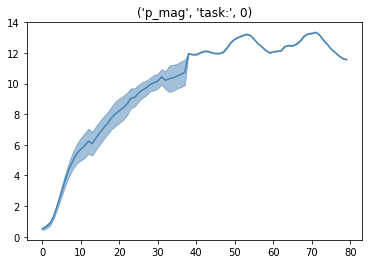

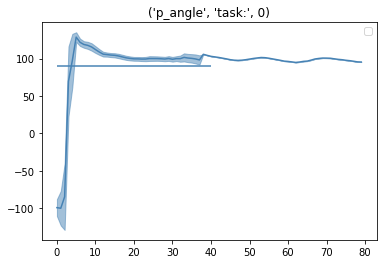

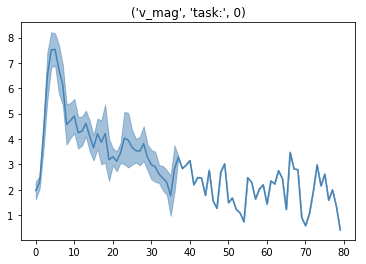

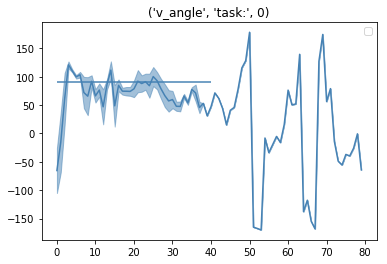

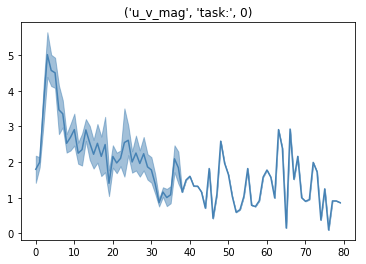

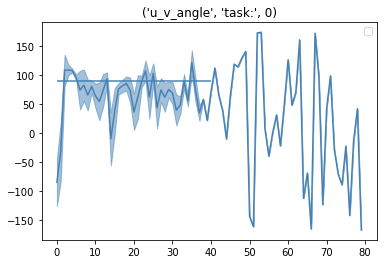

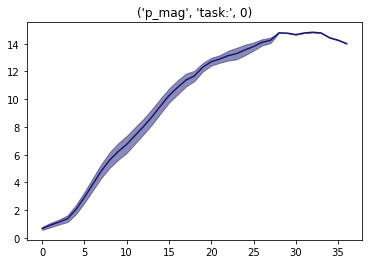

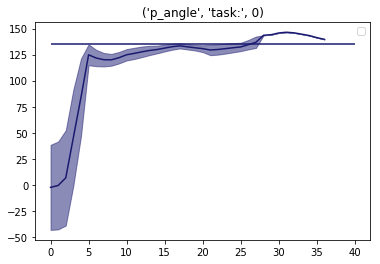

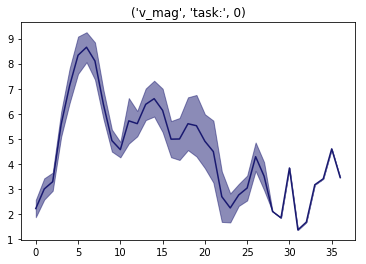

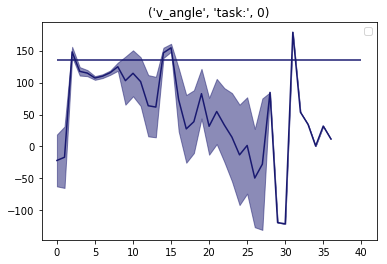

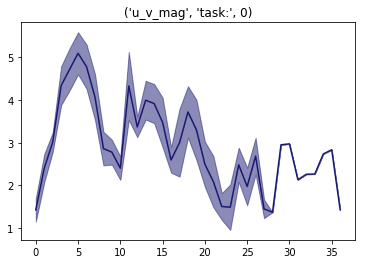

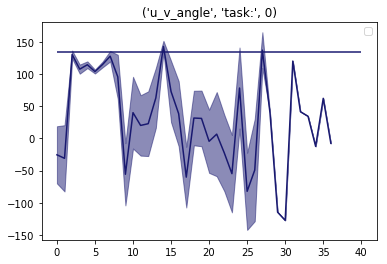

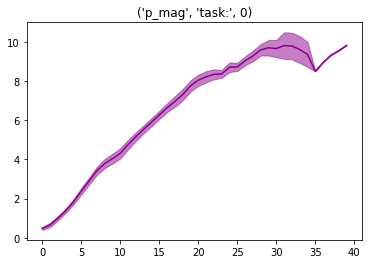

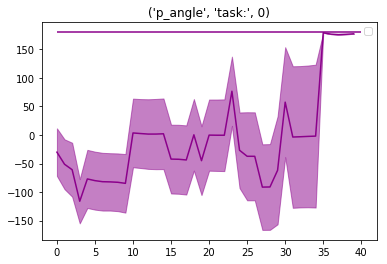

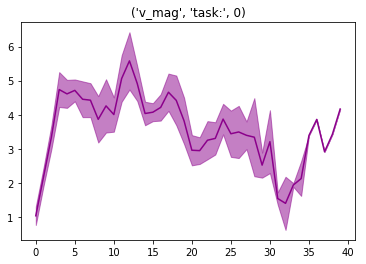

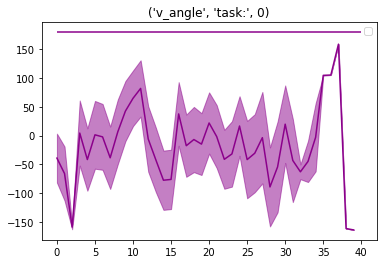

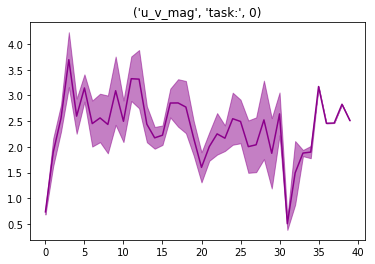

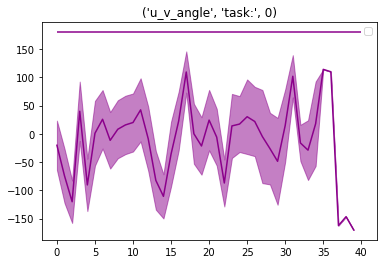

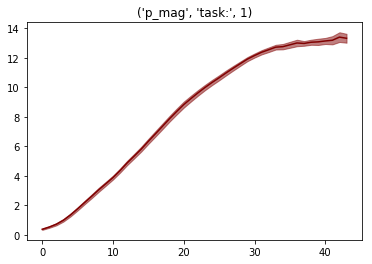

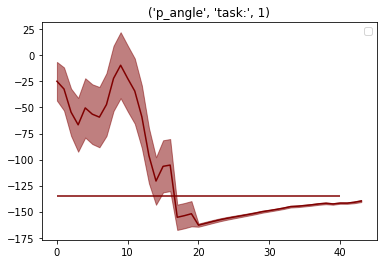

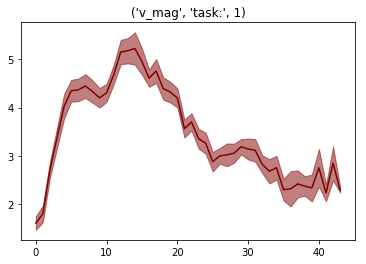

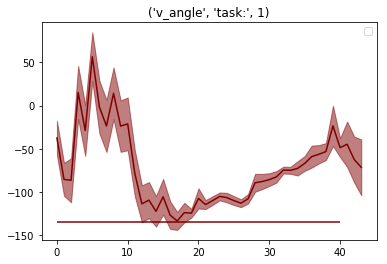

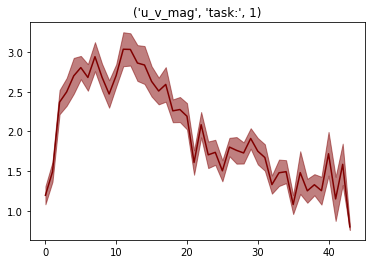

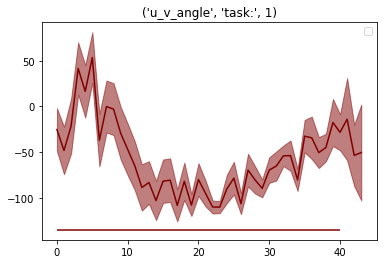

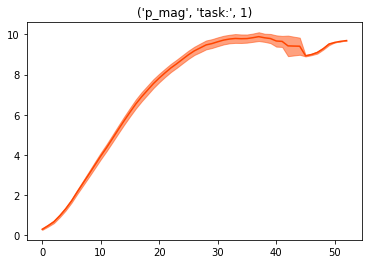

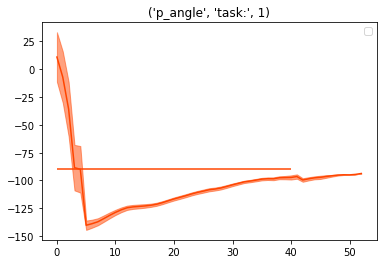

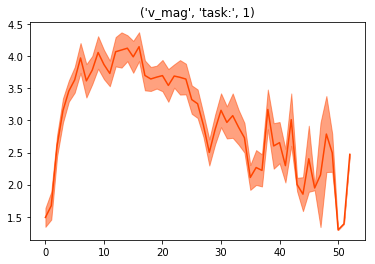

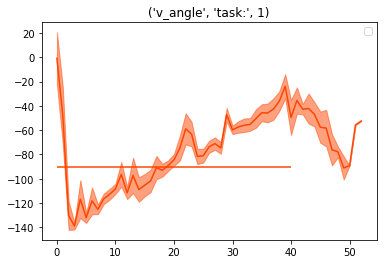

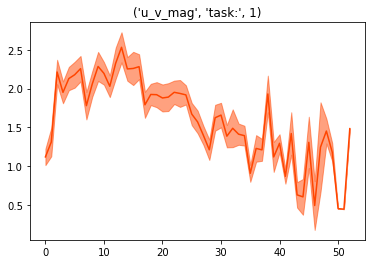

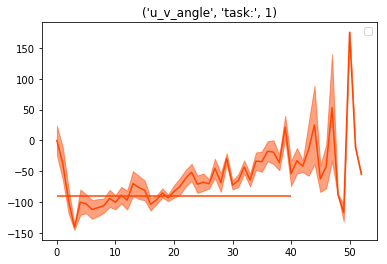

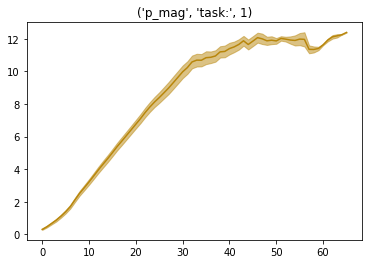

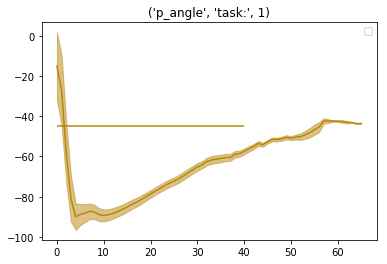

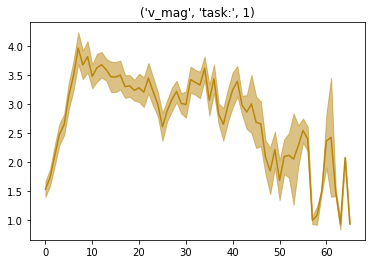

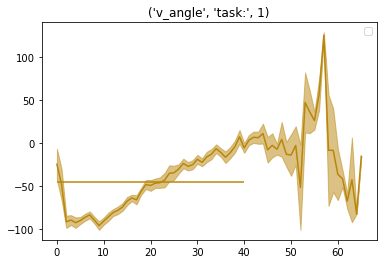

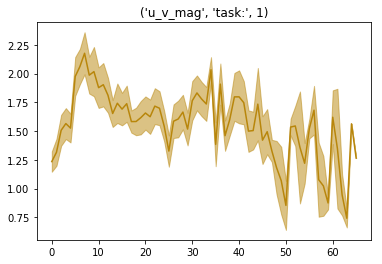

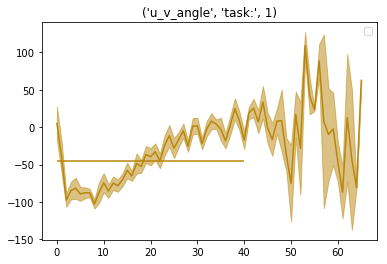

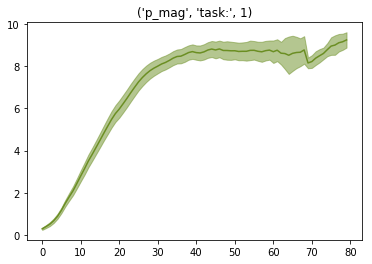

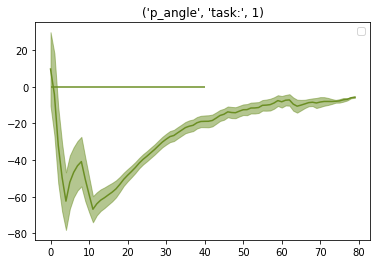

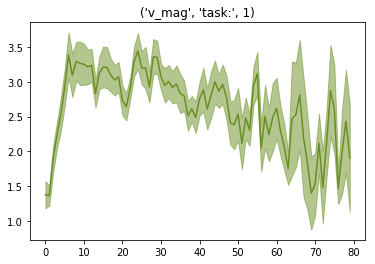

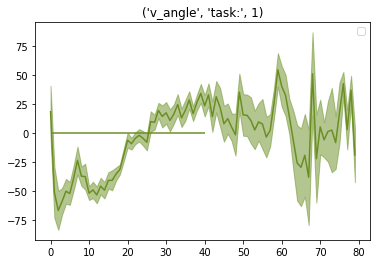

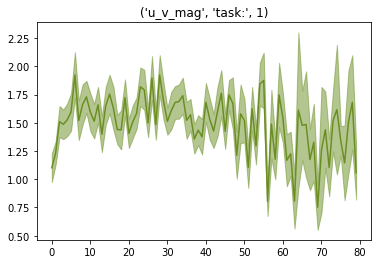

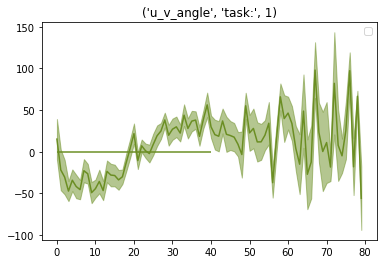

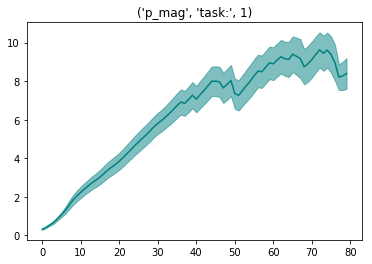

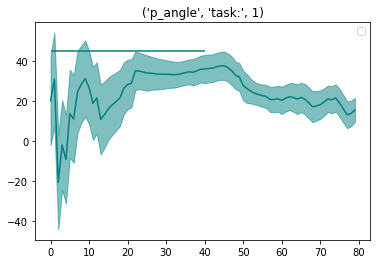

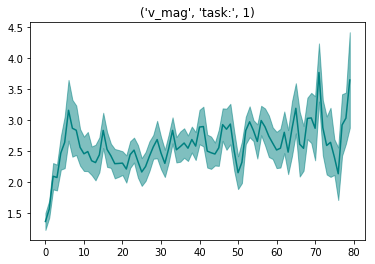

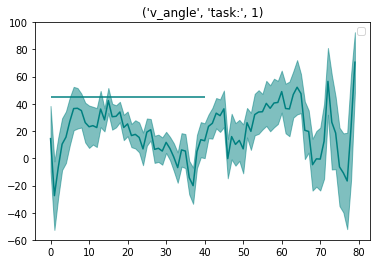

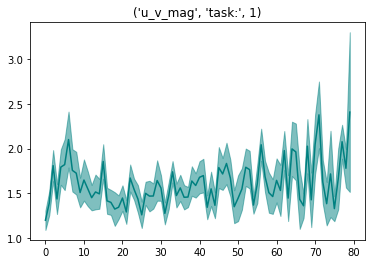

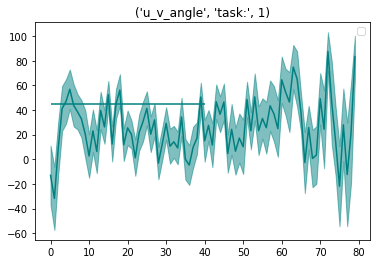

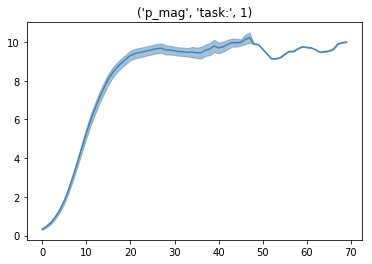

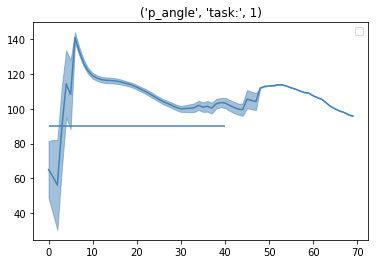

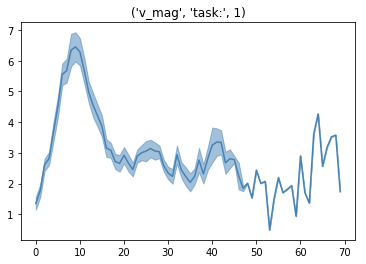

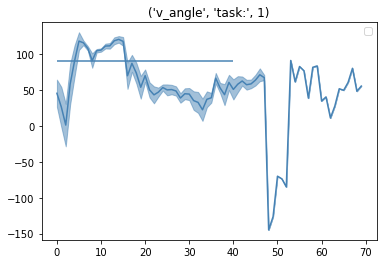

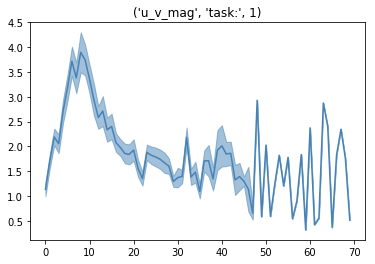

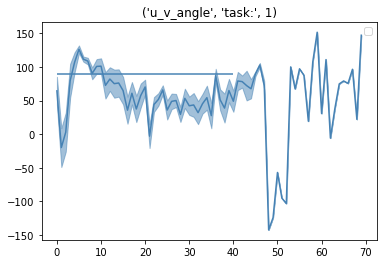

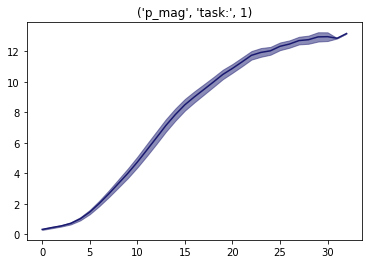

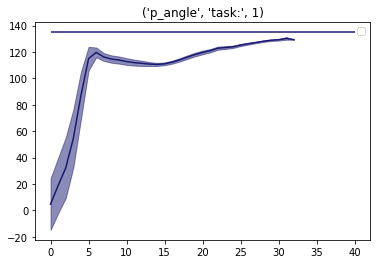

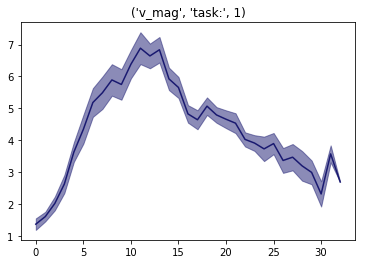

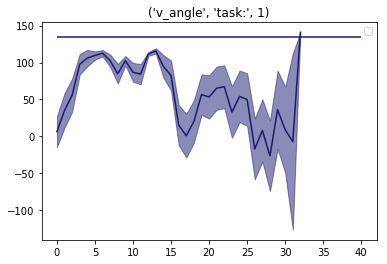

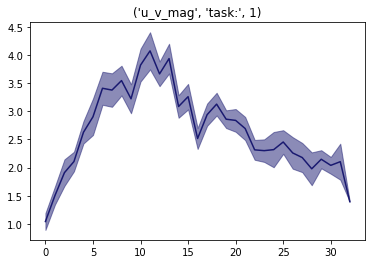

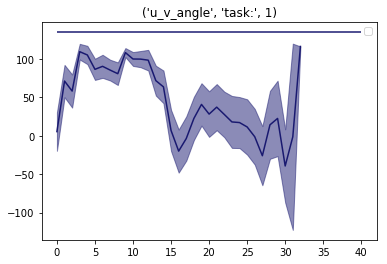

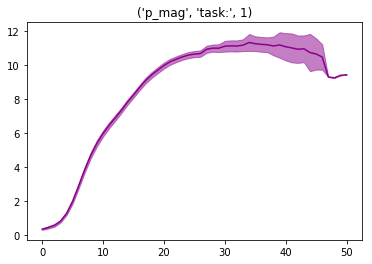

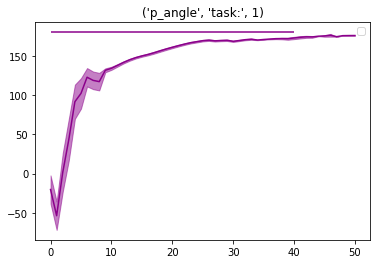

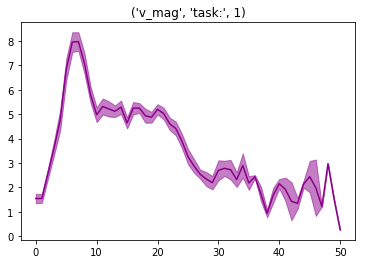

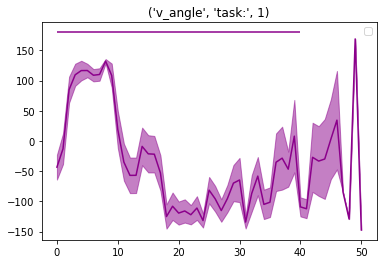

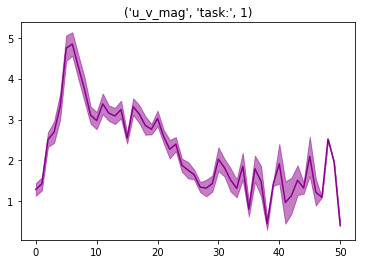

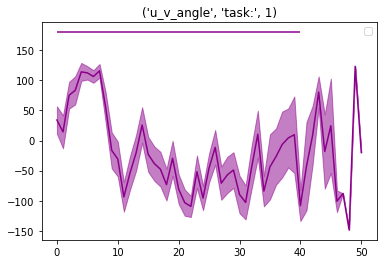

In [376]:
ctrl_list = ['p_mag', 'p_angle', 'v_mag', 'v_angle', 'u_v_mag', 'u_v_angle'] #'u_p_mag', 'u_p_angle',
task = 0
# target = 0
plot_trials =False
for task in [0,1]:
    for target in range(num_targets):
        for d in ctrl_list: 
            y = ctrl[task,target,d]
            y_mean = ctrl_psth[task,target,d,'mean']
            y_sem = ctrl_psth[task,target,d,'sem']    
            plt.figure()
            if 'angle' in d:
                y = y*180/np.pi
                y_mean = y_mean*180/np.pi
                y_sem = y_sem*180/np.pi 

                plt.hlines(target_angle[target]*180/np.pi,0,40,color=target_color[target])
                plt.legend()

            if plot_trials:
                r = plt.plot(y, color='k')


            plt.plot(y_mean, color=target_color[target])
            plt.fill_between(range(len(y)), y_mean-y_sem,y_mean+y_sem,alpha=0.5,color=target_color[target])
            plt.title((d, 'task:', task))


Text(0.5,1,'v_angle')

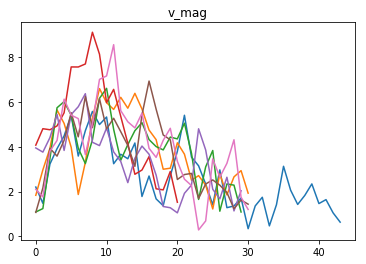

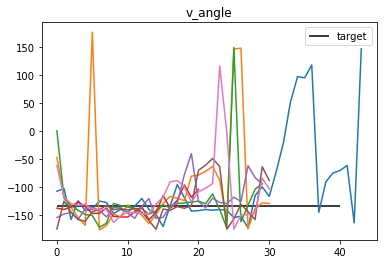

In [314]:
y = ctrl[0,0,'v_mag']
plt.figure()
r = plt.plot(y)
plt.title('v_mag')

y = ctrl[0,0,'v_angle']
plt.figure()
r = plt.plot(y*180/np.pi)
plt.hlines(target_angle[0]*180/np.pi,0,40,label='target')
plt.legend()
plt.title('v_angle')

Text(0.5,1,'u_p_angle')

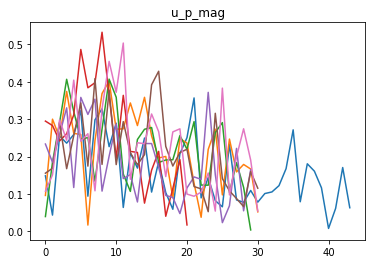

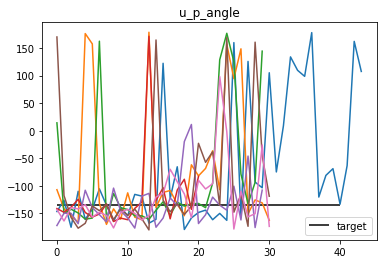

In [315]:
y = ctrl[0,0,'u_p_mag']
plt.figure()
r = plt.plot(y)
plt.title('u_p_mag')

y = ctrl[0,0,'u_p_angle']
plt.figure()
r = plt.plot(y*180/np.pi)
plt.hlines(target_angle[0]*180/np.pi,0,40,label='target')
plt.legend()
plt.title('u_p_angle')

In [ ]:
target_angle*180/np.pi

In [255]:
task

0

In [256]:
target

0

In [258]:
ctrl[task, target, 'v_mag']

array([[nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan]])

In [249]:
ctrl[task, target, 'v_angle'].shape

(80L, 27L)

In [ ]:
psth_dic = {}
for task in range(num_tasks):
    for target in range(num_targets):
        mean = da_dic[task,target].mean(axis=2,skipna=True)
        N = np.logical_not(np.isnan(da_dic[task,target])).sum(axis=2)
        var = da_dic[task,target].var(axis=2,skipna=True)
        sem = (var/N)**(0.5)
        
        psth_dic[task,target,'mean'] = mean
        psth_dic[task,target,'N'] = N
        psth_dic[task,target,'var'] = var
        psth_dic[task,target,'sem'] = sem